# Lab | Random Forests

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

In [2]:
targets = pd.read_csv('./files_for_lab/target.csv')
categorical = pd.read_csv('./files_for_lab/categorical.csv')
numerical = pd.read_csv('./files_for_lab/numerical.csv')

In [3]:
print(targets.shape)
print(categorical.shape)
print(numerical.shape)

(95412, 2)
(95412, 22)
(95412, 315)


In [4]:
print(targets.isna().sum().sum())
print(categorical.isna().sum().sum())
print(numerical.isna().sum().sum())

0
0
0


In [5]:
# targets

In [6]:
categorical

,STATE,CLUSTER,HOMEOWNR,GENDER,DATASRCE,RFA_2R,RFA_2A,GEOCODE2,DOMAIN_A,DOMAIN_B,ODATEW_YR,ODATEW_MM,DOB_YR,DOB_MM,MINRDATE_YR,MINRDATE_MM,MAXRDATE_YR,MAXRDATE_MM,LASTDATE_YR,LASTDATE_MM,FIRSTDATE_YR,FIRSTDATE_MM
0,IL,36,H,F,3,L,E,C,T,2,89,1,37,12,92,8,94,2,95,12,89,11
1,CA,14,H,M,3,L,G,A,S,1,94,1,52,2,93,10,95,12,95,12,93,10
2,NC,43,U,M,3,L,E,C,R,2,90,1,0,2,91,11,92,7,95,12,90,1
3,CA,44,U,F,3,L,E,C,R,2,87,1,28,1,87,11,94,11,95,12,87,2
4,FL,16,H,F,3,L,F,A,S,2,86,1,20,1,93,10,96,1,96,1,79,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,other,27,H,M,3,L,G,C,C,2,96,1,0,2,96,2,96,2,96,2,96,2
95408,TX,24,H,M,3,L,F,A,C,1,96,1,50,1,96,3,96,3,96,3,96,3
95409,MI,30,H,M,3,L,E,B,C,3,95,1,38,1,96,3,95,1,96,10,94,10
95410,CA,24,H,F,2,L,F,A,C,1,86,1,40,5,90,11,96,8,97,1,86,12


In [7]:
numerical

,TCODE,AGE,INCOME,WEALTH1,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,WEALTH2,POP901,POP902,POP903,POP90C1,POP90C2,POP90C3,POP90C4,POP90C5,ETH1,ETH2,ETH3,ETH4,ETH5,ETH6,ETH7,ETH8,ETH9,ETH10,ETH11,ETH12,ETH13,ETH14,ETH15,ETH16,AGE901,AGE902,AGE903,AGE904,AGE905,AGE906,AGE907,CHIL1,CHIL2,CHIL3,AGEC1,AGEC2,AGEC3,AGEC4,AGEC5,AGEC6,AGEC7,CHILC1,CHILC2,CHILC3,CHILC4,CHILC5,HHAGE1,HHAGE2,HHAGE3,HHN1,HHN2,HHN3,HHN4,HHN5,HHN6,MARR1,MARR2,MARR3,MARR4,HHP1,HHP2,DW1,DW2,DW3,DW4,DW5,DW6,DW7,DW8,DW9,HV1,HV2,HV3,HV4,HU1,HU2,HU3,HU4,HU5,HHD1,HHD2,HHD3,HHD4,HHD5,HHD6,HHD7,HHD8,HHD9,HHD10,HHD11,HHD12,ETHC1,ETHC2,ETHC3,ETHC4,ETHC5,ETHC6,HVP1,HVP2,HVP3,HVP4,HVP5,HVP6,HUR1,HUR2,RHP1,RHP2,RHP3,RHP4,HUPA1,HUPA2,HUPA3,HUPA4,HUPA5,HUPA6,HUPA7,RP1,RP2,RP3,RP4,MSA,ADI,DMA,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8,IC9,IC10,IC11,IC12,IC13,IC14,IC15,IC16,IC17,IC18,IC19,IC20,IC21,IC22,IC23,HHAS1,HHAS2,HHAS3,HHAS4,MC1,MC2,MC3,TPE1,TPE2,TPE3,TPE4,TPE5,TPE6,TPE7,TPE8,TPE9,PEC1,PEC2,TPE10,TPE11,TPE12,TPE13,LFC1,LFC2,LFC3,LFC4,LFC5,LFC6,LFC7,LFC8,LFC9,LFC10,OCC1,OCC2,OCC3,OCC4,OCC5,OCC6,OCC7,OCC8,OCC9,OCC10,OCC11,OCC12,OCC13,EIC1,EIC2,EIC3,EIC4,EIC5,EIC6,EIC7,EIC8,EIC9,EIC10,EIC11,EIC12,EIC13,EIC14,EIC15,EIC16,OEDC1,OEDC2,OEDC3,OEDC4,OEDC5,OEDC6,OEDC7,EC1,EC2,EC3,EC4,EC5,EC6,EC7,EC8,SEC1,SEC2,SEC3,SEC4,SEC5,AFC1,AFC2,AFC3,AFC4,AFC5,AFC6,VC1,VC2,VC3,VC4,ANC1,ANC2,ANC3,ANC4,ANC5,ANC6,ANC7,ANC8,ANC9,ANC10,ANC11,ANC12,ANC13,ANC14,ANC15,POBC1,POBC2,LSC1,LSC2,LSC3,LSC4,VOC1,VOC2,VOC3,HC1,HC2,HC3,HC4,HC5,HC6,HC7,HC8,HC9,HC10,HC11,HC12,HC13,HC14,HC15,HC16,HC17,HC18,HC19,HC20,HC21,MHUC1,MHUC2,AC1,AC2,CARDPROM,NUMPROM,CARDPM12,NUMPRM12,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,AVGGIFT,CONTROLN,HPHONE_D,RFA_2F,CLUSTER2
0,0,60.000000,5,9,0,0,39,34,18,10,2,1,5,992,264,332,0,35,65,47,53,92,1,0,0,11,0,0,0,0,0,0,0,11,0,0,0,39,48,51,40,50,54,25,31,42,27,11,14,18,17,13,11,15,12,11,34,25,18,26,10,23,18,33,49,28,12,4,61,7,12,19,198,276,97,95,2,2,0,0,7,7,0,479,635,3,2,86,14,96,4,7,38,80,70,32,84,16,6,2,5,9,15,3,17,50,25,0,0,0,2,7,13,27,47,0,1,61,58,61,15,4,2,0,0,14,1,0,0,2,5,17,73,0.0,177.0,682.0,307,318,349,378,12883,13,23,23,23,15,1,0,0,1,4,25,24,26,17,2,0,0,2,28,4,51,1,46,54,3,88,8,0,0,0,0,0,0,4,1,13,14,16,2,45,56,64,50,64,44,62,53,99,0,0,9,3,8,13,9,0,3,9,3,15,19,5,4,3,0,3,41,1,0,7,13,6,5,0,4,9,4,1,3,10,2,1,7,78,2,0,120,16,10,39,21,8,4,3,5,20,3,19,4,0,0,0,18,39,0,34,23,18,16,1,4,0,23,0,0,5,1,0,0,0,0,0,2,0,3,74,88,8,0,4,96,77,19,13,31,5,14,14,31,54,46,0,0,90,0,10,0,0,0,33,65,40,99,99,6,2,10,7,27,74,6,14,240.0,31,14,5.0,12.0,10.0,4,7.741935,95515,0,4,39
1,1,46.000000,6,9,16,0,15,55,11,6,2,1,9,3611,940,998,99,0,0,50,50,67,0,0,31,6,4,2,6,4,14,0,0,2,0,1,4,34,41,43,32,42,45,32,33,46,21,13,14,33,23,10,4,2,11,16,36,22,15,12,1,5,4,21,75,55,23,9,69,4,3,24,317,360,99,99,0,0,0,0,0,0,0,5468,5218,12,10,96,4,97,3,9,59,94,88,55,95,5,4,1,3,5,4,2,18,44,5,0,0,0,97,98,98,98,99,94,0,83,76,73,21,5,0,0,0,4,0,0,0,91,91,91,94,4480.0,13.0,803.0,1088,1096,1026,1037,36175,2,6,2,5,15,14,13,10,33,2,5,2,5,15,14,14,10,32,6,2,66,3,56,44,9,80,14,0,0,0,0,0,0,6,0,2,24,32,12,71,70,83,58,81,57,64,57,99,99,0,22,24,4,21,13,2,1,6,0,4,1,0,3,1,0,6,13,1,2,8,18,11,4,3,4,10,7,11,1,6,2,1,16,69,5,2,160,5,5,12,21,7,30,20,14,24,4,24,10,0,0,0,8,15,0,55,10,11,0,0,2,0,3,1,1,2,3,1,1,0,3,0,0,0,42,39,50,7,27,16,99,92,53,5,10,2,26,56,97,99,0,0,0,96,0,4,0,0,0,99,0,99,99,99,20,4,6,5,12,32,6,13,47.0,3,1,10.0,25.0,25.0,18,15.666667,148535,0,2,1
2,1,61.611649,3,1,2,0,20,29,33,6,8,1,1,7001,2040,2669,0,2,98,49,51,96,2,0,0,2,0,0,0,0,0,0,0,2,0,0,0,35,43,46,37,45,49,23,35,40,25,13,20,19,16,13,10,8,15,14,30,22,19,25,10,23,21,35,44,22,6,2,63,9,9,19,183,254,69,69,1,6,5,3,3,3,0,497,546,2,1,78,22,93,7,18,36,76,65,30,86,14,7,2,5,11,17,3,17,60,18,0,1,0,0,1,6,18,50,0,4,36,49,51,14,5,4,2,24,11,2,3,6,0,2,9,44,0.0,281.0,518.0,251,292,292,340,11576,32,18,20,15,12,2,0,0,1,20,19,24,18,16,2,0,0,1,28,8,31,11,38,62,8,74,22,0,0,0,0,0,2,2,1,21,19,24,6,61,65,73,59,70,56,78,62,82,99,4,10,5,2,6,12,0,1,9,5,18,20,5,7,6,0,11,33,4,3,2,12,3,3

We drop DOB as we already have the AGE.

In [8]:
categorical = categorical.drop('DOB_YR', axis=1).drop('DOB_MM', axis=1)

We drop TCODE, DOB, ADI, DMA, MSA and CONTROLN (it is a unique record identifier).

In [9]:
numerical = numerical.drop(['TCODE', 'ADI', 'DMA', 'MSA', 'CONTROLN'], axis=1)

RFA_2F, CLUSTER2 will be included as categorical.

In [10]:
categorical['RFA_2F'] = numerical['RFA_2F']

In [11]:
categorical['CLUSTER2'] = numerical['CLUSTER2']

In [12]:
numerical = numerical.drop(['RFA_2F', 'CLUSTER2'], axis=1)

Income, wealth1 and wealth2 are categories but can be treated with the scaler as numerical.

In [13]:
categorical = categorical.astype(str)

### Train-test split.

In [14]:
X = pd.concat([categorical, numerical], axis=1)

In [15]:
X.shape

(95412, 330)

In [16]:
y = targets.drop('TARGET_D', axis=1)

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Oversampling.

In [18]:
df_train = pd.concat([X_train, y_train], axis=1)

In [19]:
df_train_1 = df_train[df_train['TARGET_B']==1]
df_train_0 = df_train[df_train['TARGET_B']==0]

In [20]:
print(len(df_train_1))
len(df_train_0)

3690


67869

In [21]:
from sklearn.utils import resample
df_train_1_ov = resample(df_train_1, replace=True, n_samples = len(df_train_0))

In [22]:
print(len(df_train_1_ov))
len(df_train_0)

67869


67869

In [23]:
df_train_ov = pd.concat([df_train_1_ov, df_train_0], axis=0).reset_index(drop=True)

In [24]:
X_train_ov = df_train_ov.drop('TARGET_B', axis=1)
y_train_ov = df_train_ov['TARGET_B']

In [25]:
X_train_ov.isna().sum().sum()

0

In [26]:
y_train_ov.isna().sum().sum()

0

### Encoding.

Train.

In [27]:
X_train_ov_num = X_train_ov.select_dtypes(exclude=object)
X_train_ov_cat = X_train_ov.select_dtypes(include=object)

In [28]:
# X_train_ov_num

In [29]:
# X_train_ov_cat

In [30]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(drop='first', handle_unknown='ignore').fit(X_train_ov_cat)

In [31]:
X_train_cat_encoded = encoder.transform(X_train_ov_cat).toarray()

In [32]:
feature_names = encoder.get_feature_names_out(input_features=X_train_ov_cat.columns)

X_train_cat_enc = pd.DataFrame(X_train_cat_encoded, columns=feature_names)

In [72]:
# X_train_cat_enc

Test.

In [34]:
X_test_num = X_test.select_dtypes(exclude=object)
X_test_cat = X_test.select_dtypes(include=object)

In [35]:
X_test_cat_encoded = encoder.transform(X_test_cat).toarray()

c:\Users\dcast\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [14, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [36]:
feature_names = encoder.get_feature_names_out(input_features=X_test_cat.columns)

X_test_cat_enc = pd.DataFrame(X_test_cat_encoded, columns=feature_names)

In [37]:
# X_test_cat_enc

### Scaling.

Train.

In [38]:
from sklearn.preprocessing import MinMaxScaler
scaler= MinMaxScaler()

In [39]:
scaler.fit(X_train_ov_num)

MinMaxScaler()

In [40]:
X_train_num_sc = pd.DataFrame(scaler.transform(X_train_ov_num), columns=X_train_ov_num.columns)

In [41]:
# X_train_num_sc

Test.

In [42]:
X_test_num_sc = pd.DataFrame(scaler.transform(X_test_num), columns=X_test_num.columns)

In [43]:
# X_test_num_sc

### Concat.

In [44]:
X_train_tr = pd.concat([X_train_num_sc, X_train_cat_enc], axis=1)

In [45]:
X_train_tr.isna().sum().sum()

0

In [46]:
X_test_tr = pd.concat([X_test_num_sc, X_test_cat_enc], axis=1)

In [47]:
X_test_tr.isna().sum().sum()

0

In [48]:
df_train_tr = pd.concat([X_train_tr, y_train_ov], axis=1)

In [49]:
df_train_tr.isna().sum().sum()

0

In [50]:
y_test = y_test.reset_index(drop=True)

In [51]:
df_test_tr = pd.concat([X_test_tr, y_test], axis=1)

In [52]:
df_test_tr.isna().sum().sum()

0

### Random forest (1).

In [53]:
X_train = df_train_tr.drop('TARGET_B', axis=1)
y_train = df_train_tr['TARGET_B']

In [54]:
X_test = df_test_tr.drop('TARGET_B', axis=1)
y_test = df_test_tr['TARGET_B']

In [55]:
from sklearn.ensemble import RandomForestClassifier
rf1 = RandomForestClassifier(max_depth=5,
                             min_samples_split=20, # amount of rows still considered at every question
                             min_samples_leaf =20, # ultimate answer based on at least this many rows
                             max_samples=0.8,
                             )
rf1.fit(X_train, y_train)
print(rf1.score(X_train, y_train))
print(rf1.score(X_test, y_test))

0.6239078224226082
0.6027334087955394


In [56]:
from sklearn.metrics import confusion_matrix
y_pred = rf1.predict(X_test)
display(y_test.value_counts())
display(confusion_matrix(y_test, y_pred))

0    22700
1     1153
Name: TARGET_B, dtype: int64

array([[13750,  8950],
       [  526,   627]], dtype=int64)

In [57]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
print("precision: ",precision_score(y_test,y_pred))
print("recall: ",recall_score(y_test,y_pred))
print("f1: ",f1_score(y_test,y_pred))

precision:  0.06546935365980996
recall:  0.5437987857762359
f1:  0.11686859273066169


### Feature selection (variance).

In [58]:
from sklearn.feature_selection import VarianceThreshold
var_threshold = 0.02
sel = VarianceThreshold(threshold=(var_threshold))

sel = sel.fit(X_train)

sel.get_support()
var_list=list(sel.get_support())
droplist_var=[col[0] for col in zip(X_train.columns, var_list) if col[1] == False]
# print(droplist_var)
len(droplist_var)

362

In [59]:
X_train_2 = X_train.drop(droplist_var, axis=1)
X_test_2 = X_test.drop(droplist_var, axis=1)

### Random forest (2).

In [60]:
from sklearn.ensemble import RandomForestClassifier
rf2 = RandomForestClassifier(max_depth=5,
                             min_samples_split=20, # amount of rows still considered at every question
                             min_samples_leaf =20, # ultimate answer based on at least this many rows
                             max_samples=0.8,
                             )
rf2.fit(X_train_2, y_train)
print(rf2.score(X_train_2, y_train))
print(rf2.score(X_test_2, y_test))

0.6233331859906585
0.5853351779650359


In [61]:
from sklearn.metrics import confusion_matrix
y_pred_2 = rf2.predict(X_test_2)
display(y_test.value_counts())
display(confusion_matrix(y_test, y_pred_2))

0    22700
1     1153
Name: TARGET_B, dtype: int64

array([[13329,  9371],
       [  520,   633]], dtype=int64)

In [62]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
print("precision: ",precision_score(y_test,y_pred_2))
print("recall: ",recall_score(y_test,y_pred_2))
print("f1: ",f1_score(y_test,y_pred_2))

precision:  0.06327469012395041
recall:  0.5490026019080659
f1:  0.11347136326969615


### Feature selection (Selectkbest).

In [63]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
kbest = SelectKBest(chi2, k=10).fit(X_train_2, y_train)

In [64]:
df =pd.DataFrame(data = kbest.scores_, columns = ['score'])
df['Column'] = X_train_2.columns
# print(df.sort_values(by = ['score'], ascending = False))

In [65]:
cols = df.sort_values(by = ['score'], ascending = False).head(30)['Column']
type(cols)

pandas.core.series.Series

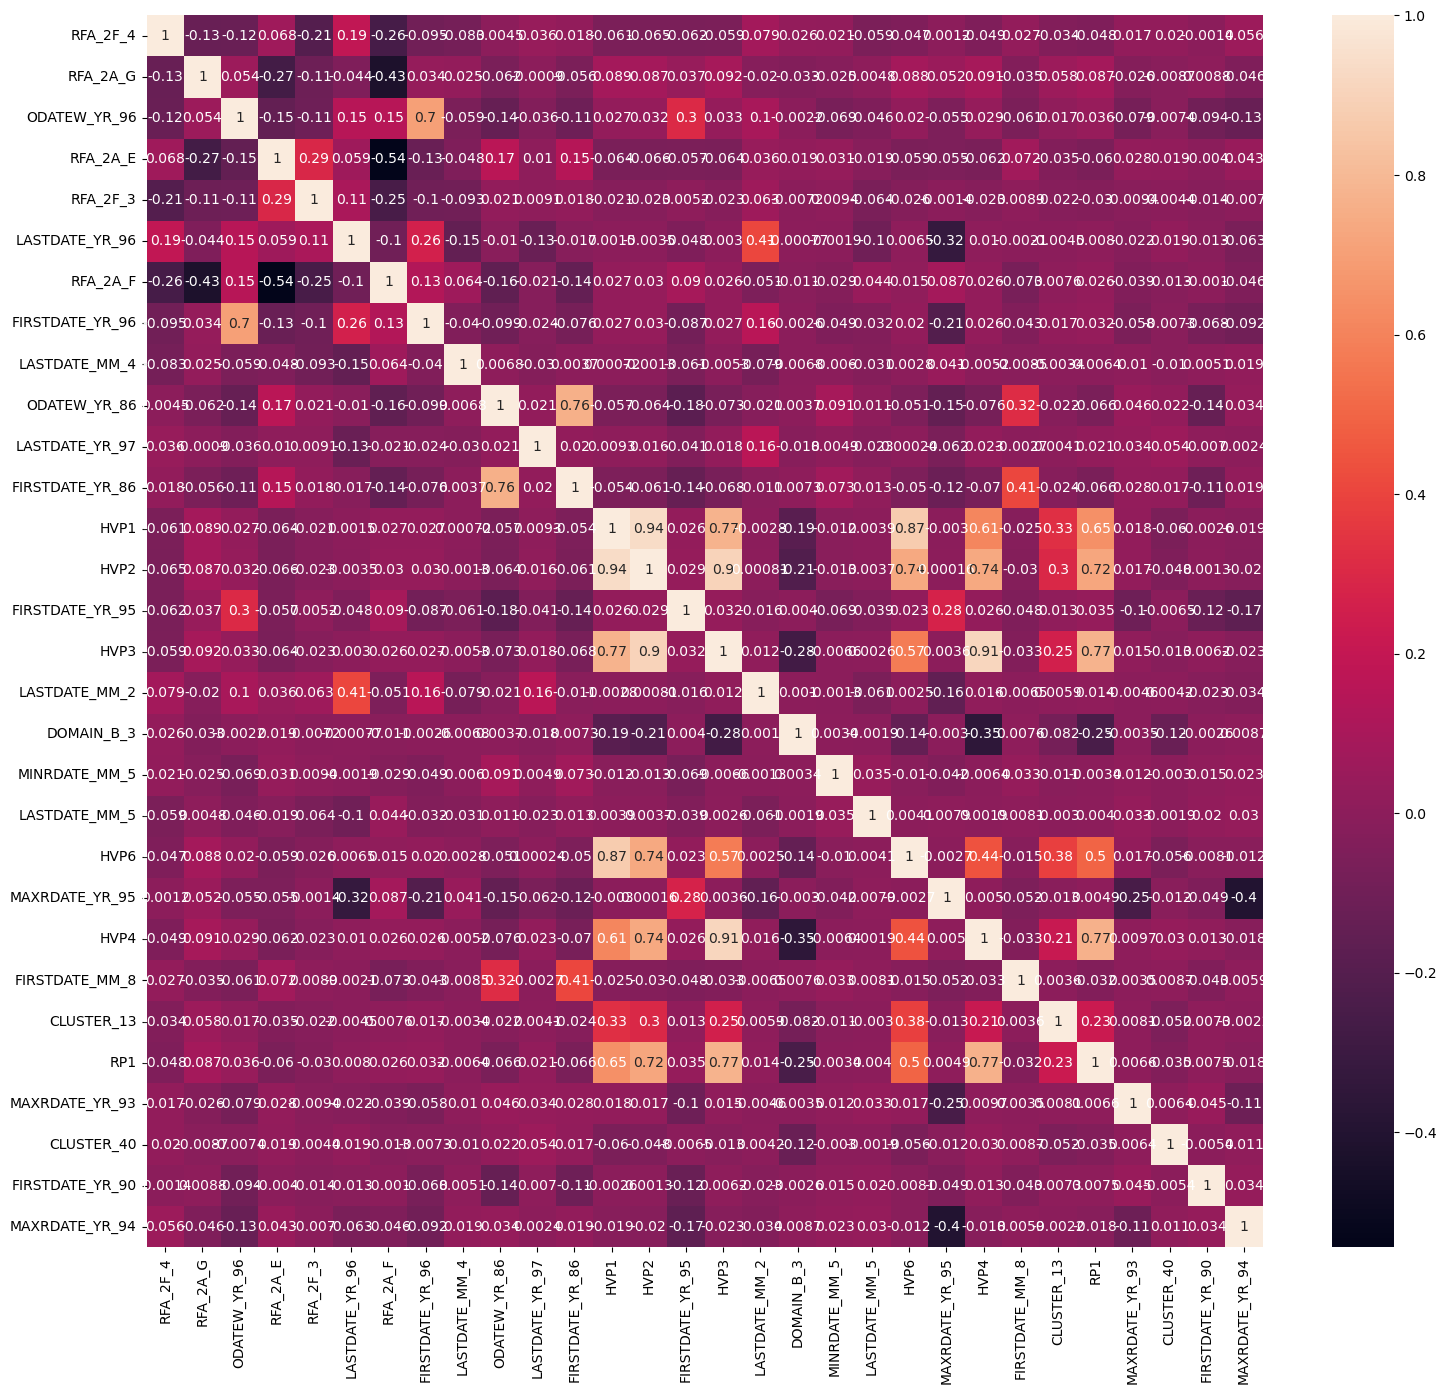

In [66]:
corr_matrix=X_train_2[cols].corr()
fig, ax = plt.subplots(figsize=(18,16))
ax = sns.heatmap(corr_matrix, annot=True)

In [67]:
X_train_3 = X_train_2[cols]
X_test_3 = X_test_2[cols]

### Random forest (3).

In [68]:
from sklearn.ensemble import RandomForestClassifier
rf3 = RandomForestClassifier(max_depth=5,
                             min_samples_split=20, # amount of rows still considered at every question
                             min_samples_leaf =20, # ultimate answer based on at least this many rows
                             max_samples=0.8,
                             )
rf3.fit(X_train_3, y_train)
print(rf3.score(X_train_3, y_train))
print(rf3.score(X_test_3, y_test))

0.5969146443884542
0.5935102502829833


In [69]:
from sklearn.metrics import confusion_matrix
y_pred_3 = rf3.predict(X_test_3)
display(y_test.value_counts())
display(confusion_matrix(y_test, y_pred_3))

0    22700
1     1153
Name: TARGET_B, dtype: int64

array([[13508,  9192],
       [  504,   649]], dtype=int64)

In [70]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
print("precision: ",precision_score(y_test,y_pred_3))
print("recall: ",recall_score(y_test,y_pred_3))
print("f1: ",f1_score(y_test,y_pred_3))

precision:  0.065948582461132
recall:  0.5628794449262793
f1:  0.11806439876296161


Discuss the output and its impact in the business scenario. Is the cost of a false positive equals to the cost of the false negative? How would you change your algorithm or data in order to maximize the return of the business?

All three models offer a similar f1 score (which takes into acocunt both precision and recall). In this case, we are interested in both metrics, but particularly in recall, as we want to be able to identify as many actual donors as possible.